# Train Your Fly - Quickstart

This notebook demonstrates how to train a neural network using the **Drosophila connectome** as the network architecture.

The model processes images through:
1. **Voronoi tessellation** - mimicking the fly's compound eye structure
2. **Photoreceptor activation** - R1-6, R7, R8 neurons respond to different wavelengths
3. **Message passing** - signals propagate through the biological connectome graph
4. **Decision layer** - specific neuron types aggregate for classification

## 1. Setup and Imports

In [1]:
import random
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from tqdm.auto import tqdm

from trainyourfly.config import Config
from trainyourfly.data.data_processing import DataProcessor
from trainyourfly.connectome_models.graph_models import FullGraphModel
from trainyourfly.utils.utils import get_image_paths

/home/eudald/Escriptori/doctorat/train-your-fly/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

You can create a config in three ways:
- **Create example YAML**: `Config.create_example("config.yaml")` - creates a documented template
- **From YAML file**: `Config.from_yaml("config.yaml")` - load from file
- **Direct instantiation**: `Config(batch_size=8, num_epochs=10)` - in Python

In [2]:
# Option 1: Create an example config.yaml (uncomment to create)
# Config.create_example("my_config.yaml")  # Creates a documented template

# Option 2: Load from existing YAML
config = Config.from_yaml("config.yaml")

# Option 3: Direct instantiation
# config = Config(
#     data_dir="data",           # Path to your data folder (with train/ and test/)
#     batch_size=8,
#     NUM_CONNECTOME_PASSES=3,   # Message passing iterations
# )

# Set seeds for reproducibility
if config.random_seed is not None:
    torch.manual_seed(config.random_seed)
    np.random.seed(config.random_seed)
    random.seed(config.random_seed)

print(f"Device: {config.DEVICE}")
print(f"Batch size: {config.batch_size}")
print(f"Connectome passes: {config.NUM_CONNECTOME_PASSES}")
print(f"Data: {config.data_dir}")

Device: cuda
Batch size: 8
Connectome passes: 3
Data: ans


## 3. Initialize Data Processor and Model

The `DataProcessor` loads the connectome data and sets up the Voronoi tessellation based on photoreceptor positions.

In [3]:
# Load training images
train_images = get_image_paths(config.TRAINING_DATA_DIR)
print(f"Found {len(train_images)} training images")

# Initialize the data processor (loads connectome, creates Voronoi tessellation)
data_processor = DataProcessor(config)
print(f"Classes: {data_processor.classes}")
print(f"Number of neurons in connectome: {len(data_processor.root_ids)}")

# Create the connectome-based model
model = FullGraphModel(data_processor, config).to(config.DEVICE)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Found 1120 training images
Classes: ['blue', 'yellow']
Number of neurons in connectome: 138639
Trainable parameters: 15,091,987


## 4. Single Forward Pass

Let's see what a single batch looks like going through the network.

In [4]:
# Process a single batch
batch_paths = train_images[:config.batch_size]
images, labels = data_processor.get_data_from_paths(batch_paths)
inputs, labels = data_processor.process_batch(images, labels)

print(f"Input batch: {config.batch_size} images")
print(f"Labels: {labels}")

# Forward pass
with torch.no_grad():
    outputs = model(inputs)

print(f"\nOutput shape: {outputs.shape}")
print(f"Output (logits):\n{outputs}")
print(f"\nPredicted classes: {outputs.argmax(dim=1)}")

Input batch: 8 images
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

Output shape: torch.Size([8, 2])
Output (logits):
tensor([[-0.2466,  0.1240],
        [-0.2617,  0.1205],
        [-0.2591,  0.1211],
        [-0.1994,  0.1347],
        [-0.2533,  0.1224],
        [-0.2511,  0.1229],
        [-0.2550,  0.1220],
        [-0.2572,  0.1216]], device='cuda:0')

Predicted classes: tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


## 5. Training Loop

Now let's train the model for a few epochs. The trainable parameters are the **synaptic weights** of the connectome.

In [5]:
# Training configuration
NUM_EPOCHS = 3
LEARNING_RATE = config.base_lr

# Setup optimizer and loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Calculate iterations per epoch
iterations_per_epoch = min(len(train_images) // config.batch_size, 50)  # Cap at 50 for demo
print(f"Training for {NUM_EPOCHS} epochs, {iterations_per_epoch} iterations each")

Training for 3 epochs, 50 iterations each


In [6]:
def select_batch(all_paths, batch_size, used):
    """Select a random batch avoiding recently used images."""
    available = [p for p in all_paths if p not in used]
    if len(available) < batch_size:
        available = all_paths
        used.clear()
    selected = random.sample(available, min(batch_size, len(available)))
    used.extend(selected)
    return selected, used

# Training loop
model.train()
history = {'loss': [], 'accuracy': []}

for epoch in range(NUM_EPOCHS):
    used_images = []
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(range(iterations_per_epoch), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for i in pbar:
        # Get batch
        batch_paths, used_images = select_batch(train_images, config.batch_size, used_images)
        images, labels = data_processor.get_data_from_paths(batch_paths)
        inputs, labels = data_processor.process_batch(images, labels)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()   
        
        pbar.set_postfix({
            'loss': f'{running_loss/(i+1):.4f}',
            'acc': f'{100.*correct/total:.1f}%'
        })
    
    epoch_loss = running_loss / iterations_per_epoch
    epoch_acc = 100. * correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.1f}%")

print("\nTraining complete!")

Epoch 1/3: 100%|██████████| 50/50 [00:15<00:00,  3.29it/s, loss=0.7106, acc=49.8%]


Epoch 1: Loss = 0.7106, Accuracy = 49.8%


Epoch 2/3: 100%|██████████| 50/50 [00:15<00:00,  3.31it/s, loss=0.7125, acc=48.5%]


Epoch 2: Loss = 0.7125, Accuracy = 48.5%


Epoch 3/3: 100%|██████████| 50/50 [00:13<00:00,  3.66it/s, loss=0.7013, acc=51.2%]

Epoch 3: Loss = 0.7013, Accuracy = 51.2%

Training complete!


## 6. Results

Let's visualize the training progress.

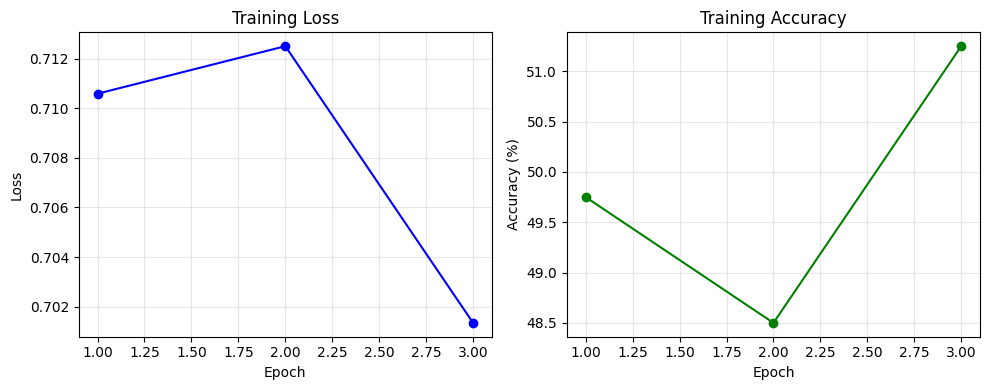

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(range(1, NUM_EPOCHS + 1), history['loss'], 'b-o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, NUM_EPOCHS + 1), history['accuracy'], 'g-o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Configuration

You can save your current configuration to a YAML file for later use.

In [ ]:
# Save the current config to a YAML file
# config.to_yaml("my_experiment_config.yaml")
# print("Config saved!")

## Next Steps

- Increase `NUM_EPOCHS` for better convergence
- Try different `NUM_CONNECTOME_PASSES` (more passes = deeper signal propagation)
- Experiment with `filtered_fraction` to ablate neurons
- Modify `config.yaml` for persistent configuration
- Check `examples/simple_training.py` for a complete training script with evaluation